In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    #attn_implementation="flash_attention_2",
    device_map="auto",
)

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
min_pixels = 256*28*28 / 2
max_pixels = 1280*28*28 / 2
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

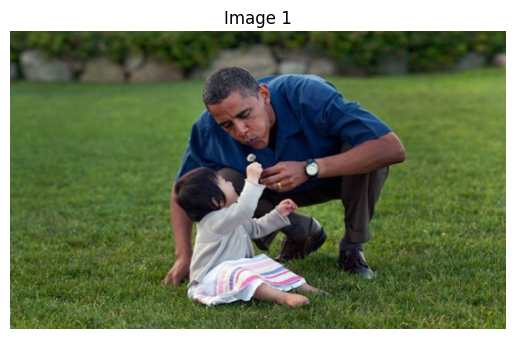

['这张图片中，奥巴马穿着蓝色衬衫和棕色裤子，跪在地上和一个小女孩玩耍。小女孩穿着白色和粉色相间的裙子，坐在草地上。背景是一片绿色的草坪和一些岩石。']


In [2]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "http://www.people.com.cn/mediafile/pic/20121113/24/370770879445422736.jpg",
            },
            {"type": "text", "text": "Describe this image in Chinese."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

import matplotlib.pyplot as plt
for i, img in enumerate(image_inputs):
    plt.figure()
    plt.imshow(img)
    plt.title(f'Image {i + 1}')
    plt.axis('off')
    plt.show()

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)